In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tensorflow.keras.datasets.mnist import load_data
(x_train,y_train),(x_test,y_test) = load_data()

#We have 60000 images for training which are enough, but doesnot have any validation dataset

#Dividing test dataset of 10000 images into 5000 test dataset and 5000 validate dataset
from sklearn.model_selection import train_test_split
x_test,x_validate,y_test,y_validate = train_test_split(x_test,y_test, test_size=0.5)

In [3]:
#Shapes of datasets

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_validate.shape)
print(y_validate.shape)

(60000, 28, 28)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


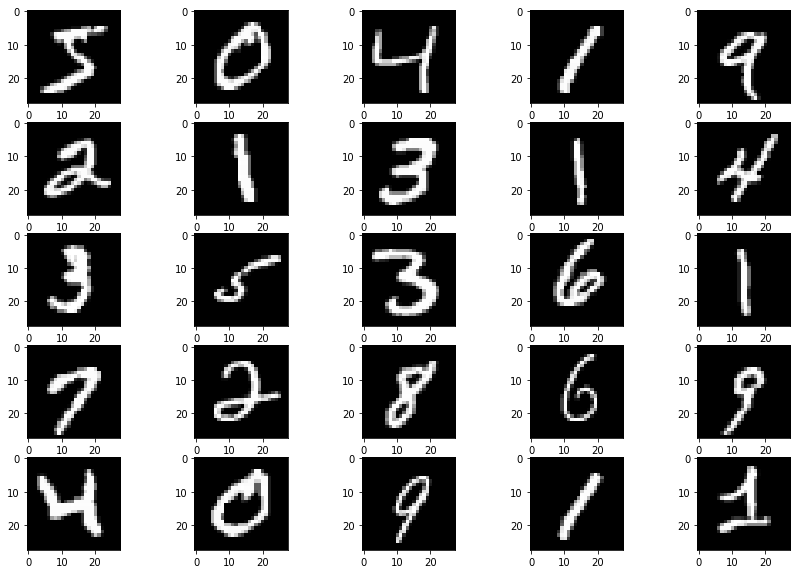

In [4]:
#Plotting first 25 images fron training dataset
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.subplots_adjust(right=2, top=2)

In [5]:
#CNN takes 4 parameters as input. 
# First is number of images.
# Second and third are dimensions of image. In this case it is 28x28.
# Fourth is the number of color channel. In this case it is 1.

x_train = x_train.reshape(x_train.shape[0],28,28,1)
y_train = pd.get_dummies(y_train).values
x_test = x_test.reshape(x_test.shape[0],28,28,1)
y_test = pd.get_dummies(y_test).values
x_validate = x_validate.reshape(x_validate.shape[0],28,28,1)
y_validate = pd.get_dummies(y_validate).values

#Scaling pixel values from 0 to 1
x_train = x_train/255.
x_test = x_test/255.
x_validate = x_validate/255.

In [6]:
#CNN in tensorflow
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None,28,28,1], name="Input")
Y = tf.placeholder(tf.float32,[None,10])

#Convolution 2D helper funtion
def conv2d(X,weights):
    conv_layer = tf.nn.conv2d(X,weights,strides=[1,1,1,1], padding = "SAME")
    conv_layer = tf.nn.relu(conv_layer)
    return conv_layer

#Max pooling helper function
def maxpool(X):
    pool_layer = tf.nn.max_pool(X,ksize=[1,2,2,1],strides=[1,2,2,1],padding= "SAME")
    return pool_layer

#Defining different filters.
#First CNNN layer has 32 filters, second has 64 filters and third has 128 filters. All these filters has a size of 3x3.

weights = {
    'wc1': tf.get_variable("wc1", shape= [3,3,1,32], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc2': tf.get_variable("wc2", shape= [3,3,32,64], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc3': tf.get_variable("wc3", shape= [3,3,64,128], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'flw': tf.get_variable("flw", shape= [4*4*128,128], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'out': tf.get_variable("out_ww", shape= [128,10], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
}
baises = {
    'bc1': tf.get_variable("bc1", shape= [32], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'bc2': tf.get_variable("bc2", shape= [64], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'bc3': tf.get_variable("bc3", shape= [128], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'flb': tf.get_variable("flb", shape= [128], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'out': tf.get_variable("out_b", shape= [10], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
}

# Convolutional Neural Network
def conv_net(X,weights,baises):
    conv1 = conv2d(X,weights['wc1'])  + baises['bc1']
    conv1 = maxpool(conv1)
    conv2 = conv2d(conv1,weights['wc2'])  + baises['bc2']
    conv2 = maxpool(conv2)
    conv3 = conv2d(conv2,weights['wc3'])  + baises['bc3']
    conv3 = maxpool(conv3)
    flat_layer = tf.reshape(conv3,[-1,4*4*128])
    flat_layer = tf.nn.relu(tf.matmul(flat_layer,weights['flw']) + baises['flb'])
    out = tf.matmul(flat_layer,weights['out']) + baises['out']
    return out
    
Y_p = conv_net(X,weights,baises)

Y_p = tf.identity(Y_p, name="Prediction")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels =Y,logits = Y_p)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y,1),tf.argmax(Y_p,1)), tf.float32))

optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
#Training
# This will stop when the accuracy on validation set start decreasing. This will prevent overfitting.
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    previous_validate_accuracy = 0
    e=0
    validate_accuracy = 1
    while True:
        e += 1
        start =0
        training_accuracy =0
        while start < x_train.shape[0]:
            batch_x = x_train[start:start+1000]
            batch_y = y_train[start:start+1000]
            start += 1000
            sess.run(optimizer,{X:batch_x,Y:batch_y})
            training_accuracy += sess.run(accuracy,{X:batch_x,Y:batch_y})
        training_accuracy = training_accuracy/(x_train.shape[0]/1000)
        
        validate_accuracy = sess.run(accuracy,{X:x_validate,Y:y_validate})
        
        print("Epoch : {} | Training Accuracy : {:.3f}% | Validation Accuracy : {:.3f}%".format(e,training_accuracy,validate_accuracy))
        
        if validate_accuracy < previous_validate_accuracy:
            break
        
        previous_validate_accuracy = validate_accuracy
        
        
    acc = sess.run(accuracy, {X:x_test,Y:y_test})
    print("Accuracy on test dataset : {:.3f}".format(acc))
    
    saver.save(sess,'Model/saved_model')

    

Epoch : 1 | Training Accuracy : 0.702% | Validation Accuracy : 0.896%
Epoch : 2 | Training Accuracy : 0.939% | Validation Accuracy : 0.958%
Epoch : 3 | Training Accuracy : 0.966% | Validation Accuracy : 0.972%
Epoch : 4 | Training Accuracy : 0.975% | Validation Accuracy : 0.976%
Epoch : 5 | Training Accuracy : 0.980% | Validation Accuracy : 0.979%
Epoch : 6 | Training Accuracy : 0.983% | Validation Accuracy : 0.980%
Epoch : 7 | Training Accuracy : 0.985% | Validation Accuracy : 0.981%
Epoch : 8 | Training Accuracy : 0.987% | Validation Accuracy : 0.984%
Epoch : 9 | Training Accuracy : 0.988% | Validation Accuracy : 0.986%
Epoch : 10 | Training Accuracy : 0.990% | Validation Accuracy : 0.984%
Accuracy on test dataset : 0.987
